In [9]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import numpy as np
import cv2
from tensorflow.keras.applications import VGG16
from matplotlib import pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import DenseNet169,Xception
import os
from fullgrad import FullGrad
import ast

In [10]:
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
with open('imagenet1000_clsidx_to_labels.txt') as imagenet_classes_file:
    imagenet_classes_dict = ast.literal_eval(imagenet_classes_file.read())

--2021-06-09 12:08:53--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsidx_to_labels.txt.1’

imagenet1000_clsidx 100%[===================>]  29.85K  --.-KB/s    in 0.007s  

2021-06-09 12:08:54 (4.41 MB/s) - ‘imagenet1000_clsidx_to_labels.txt.1’ saved [30564/30564]



In [11]:
K.clear_session()

base_models=[VGG16(weights='imagenet')]
base_preprocess=[vgg_preprocess]
base_model_names=['VGG']

In [12]:
for base_model in base_models:
    '''
    completeness check with random input eg: a tensor of ones
    '''
    input_=np.ones(shape=(1,base_model.layers[0].input_shape[0][1],base_model.layers[0].input_shape[0][2],base_model.layers[0].input_shape[0][3])).astype(np.float32)
    '''
    since the fullgrad model deals with representation of relu layers, 
    last layer softmax is removed and it's input features are mul with 
    weights and added with bias of last layer.

    This process can be ignored as it is done to manually check 
    base model output and fullgrad sum. 
    '''
    newmodel=Model(base_model.input,base_model.layers[-2].output)
    feat=newmodel.predict(input_)
    base_weights=base_model.get_weights()
    out_=feat.dot(base_weights[-2])+base_weights[-1]
    '''
    create fullgrad model and check for it's completeness
    Note: default num classes is 1000
    '''
    fullgrad=FullGrad(base_model)
    fullgrad.checkCompleteness(input_)
    print('###############################')

class: 669 class name: None
Running completeness test.....
final_layer_max_class_linear_output: 3.456264
sum of FullGrad: 3.456264
Completeness test passed for FullGrad.
###############################


In [13]:
img_path = "/Users/vaibhavsingh/Desktop/TensorFlowASR/tensorflow_asr/fullGrad/images/2007_000256.jpeg"

class: 404 class name: airliner


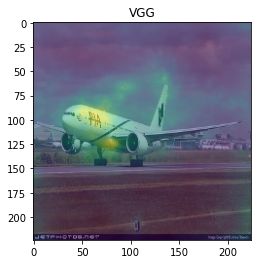

In [14]:
for base_model,preprocess,name in zip(base_models,base_preprocess,base_model_names):
    '''
    image loading and preprocessing
    '''
    img = load_img(img_path, target_size=(base_model.layers[0].input_shape[0][1],base_model.layers[0].input_shape[0][2]))
    img= img_to_array(img)
    input_= np.expand_dims(img, axis=0)
    input_=preprocess(input_)
    '''
    since the fullgrad model deals with representation of relu layers, 
    last layer softmax is removed and it's input features are mul with 
    weights and added with bias of last layer.

    This process can be ignored as it is done to manually check 
    base model output and fullgrad sum.

    '''
    #newmodel=Model(base_model.input,base_model.layers[-2].output)
    #feat=newmodel.predict(input_)
    #base_weights=base_model.get_weights()
    #out_=feat.dot(base_weights[-2])+base_weights[-1]

    '''
    create fullgrad model and fullgrad saliency for the
    given input . fullgrad completeness check can be done
    or ignored here if prevously done once.

    Note: default num classes is 1000 , for custom model use
    FullGrad(base_model,num_classes)
    '''
    fullgrad=FullGrad(base_model,class_names=imagenet_classes_dict)
    #fullgrad.checkCompleteness(input_)
    cam=fullgrad.saliency(input_)
    cam=fullgrad.postprocess_saliency_map(cam[0])
    plt.title(name)
    plt.imshow(cv2.resize(plt.imread(img_path),(base_model.layers[0].input_shape[0][1],base_model.layers[0].input_shape[0][2])))
    plt.imshow(cam,alpha=0.5)
    plt.show()  